In [1]:
import time
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
import sys
import Dataloader_patches
import Dataloader_slice_parts
import Dataloader_whole_slices
import Rotation_transform

/home/christoph/Dokumente/christoph-MA/MAenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_path = "/storage/Datensätze"
dataset = Dataloader_slice_parts.VolumeToSlicepartsDataset(root_dir=data_path,test=True,augmentation="elastic")

/storage/Datensätze/lung_test
/storage/Datensätze/lung_test/tom_2023-10-10-10-05-25_00.raw
/storage/Datensätze/lung_test/tom_2023-10-10-11-23-15_00.raw
/storage/Datensätze/skin_test
/storage/Datensätze/skin_test/tom_2024-01-26-10-40-06_00.raw
/storage/Datensätze/skin_test/tom_2024-03-29-10-41-00_00.raw
/storage/Datensätze/skin_test/tom_2024-01-25-17-52-24_00.raw
/storage/Datensätze/intestine_test
/storage/Datensätze/intestine_test/tom_2024-06-18-13-23-38_00.raw
/storage/Datensätze/intestine_test/tom_2023-08-30-14-36-45_00.raw


In [ ]:
import elasticdeform.torch as etorch

In [3]:
sample = dataset.__getitem__(100000%77039)
deformed_sample = dataset.__getitem__(100000)

In [18]:
dataset.__len__()/2

77039.0

In [ ]:
import elasticdeform

deformed =  elasticdeform.deform_random_grid(sample[0], sigma=2, axis=(0, 1, 2),order=1, mode='constant')

In [ ]:
image, label = dataset.__getitem__(1714+1000)

image_untransformed, label = dataset.__getitem__(1000)

In [ ]:
print(image_untransformed.shape)
transform = Rotation_transform.RandomRotate2D()

rotated_image = transform(image_untransformed)
print(rotated_image.shape)

In [ ]:
count = 0
for i in range(int(dataset.__len__()/2)):

    image, label = dataset.__getitem__(dataset.__len__()//2+i)
    print(image.shape)
    image_untransformed, label = dataset.__getitem__(i)
    if image.equal(image_untransformed):
        print("equal")
        count += 1
print(count)


In [ ]:
import torchio.transforms as tio

elastic_def = tio.RandomElasticDeformation(num_control_points=(5,9,9),locked_borders=2,max_displacement=(2,10,10)) 
sample = torch.tensor(sample[0])
deformed_tio = elastic_def(sample[0])

In [ ]:
image_rotated = Rotation_transform.RandomRotate2D()(image_untransformed)

In [ ]:
sample[0].shape

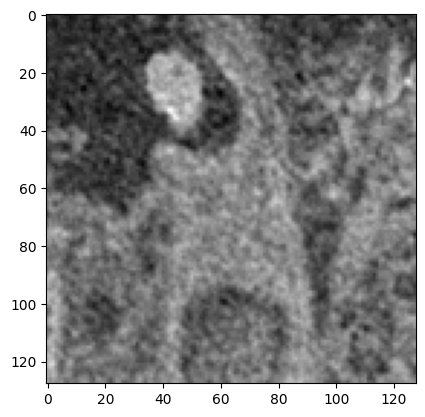

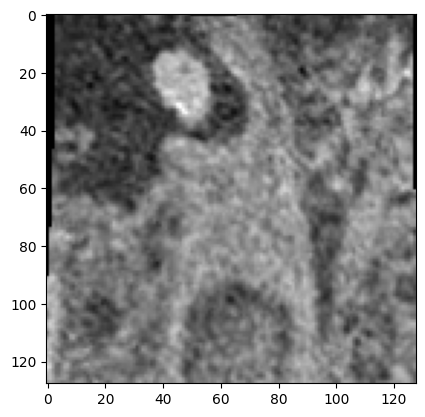

In [8]:
import matplotlib.pyplot as plt
plt.imshow(sample[0][1,:,:], cmap='gray')#,vmin=24000, vmax=45000)
plt.show()
plt.imshow(deformed_sample[0][1,:,:], cmap='gray')#,vmin=24000, vmax=45000)
plt.show()

In [ ]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

In [ ]:
model = SwinUNETR.swin_unetr_base(input_size=(128,128,32))

In [ ]:
model.swinViT.layers4[0].downsample.reduction = nn.Linear(3072,3)
model.swinViT.layers4[0].downsample.norm= nn.Identity(3,3)

In [ ]:
print(model)

In [ ]:
model.eval()
random_tensor = torch.randn(1,1,128, 128, 32)
print(random_tensor.shape)

outout = model(random_tensor)

In [ ]:
print(outout.shape)
print(outout[0])
import torch.nn.functional as F
print(F.softmax(outout[0], dim=0))  

In [ ]:
model = models.video.r3d_18()

In [ ]:
model = models.video.swin3d_b(models.video.Swin3D_B_Weights.KINETICS400_V1)

In [ ]:
model.eval()

# Create a dummy input: (batch=1, channels=3, time=32, height=224, width=224)
dummy_input = torch.randn(1, 3, 1, 1)

# Run a forward pass to confirm it works
with torch.no_grad():
    output = model(dummy_input)

print("Output shape:", output.shape)

In [ ]:
m = nn.AdaptiveAvgPool2d((5, 7))
input = torch.randn(1, 64, 8, 9)
output = m(input)
print(output.shape)
# target output size of 7x7 (square)
m = nn.AdaptiveAvgPool2d(3)
input = torch.randn(1, 2, 2)
print(input)
output = m(input)
print(output.shape)
print(output)
# target output size of 10x7
m = nn.AdaptiveAvgPool2d((None, 7))
input = torch.randn(1, 64, 10, 9)
output = m(input)
print(output.shape)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import transforms
from torchvision.models import video
from torch.utils.data import DataLoader
import sys
sys.path.append('/home/christoph/Dokumente/christoph-MA/MA-Repo')
import Aggregator_Module
import Dataloader_slice_parts_aggregator
from train import train_model
from eval import evaluate_model
from collections import OrderedDict

data_path = "/storage/Datensätze"

device = torch.device("cuda")

encoder = video.r3d_18(pretrained=True)

encoder.to(device)

num_ftrs = encoder.fc.out_features

dropout = 0

decoder_enc = nn.Sequential(
                            nn.Linear(num_ftrs, 128),
                            nn.GELU(),
                            nn.Dropout(dropout)
                            )

model = Aggregator_Module.AttnMeanPoolMIL(gated=True, dropout=dropout, out_dim=3,encoder=decoder_enc,encoder_dim=128)

model.start_attention(freeze_encoder=False)

batch_size = 8

epochs = 50

dataset = Dataloader_slice_parts_aggregator.VolumeToSlicepartsDataset(data_path, transform=None, test=True,encoder=encoder,augmentation="tripath")

train_set, val_set = torch.utils.data.random_split(dataset, [int(0.9 * len(dataset)), len(dataset) - int(0.9 * len(dataset))])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)



In [ ]:
features,labels = dataset.__getitem__(0)
print(features.shape)
print(labels)

In [ ]:
import torch.nn.functional as F
model = model.to(device)


output = model(features.unsqueeze(0))
print((output))

In [ ]:
_, preds = torch.max(output, 1)

In [ ]:
preds.item()

In [ ]:
for patch in patches:
    print(patch.shape)

In [ ]:
import matplotlib.pyplot as plt
for patch in patches:
    plt.imshow(patch[:,:], cmap='gray')
    plt.show()

In [ ]:
tensor = torch.randn(10,3,128,128,32)

In [ ]:
input = torch.tensor1,tensor

In [ ]:
out =  aggregator_model(tensor)